In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import numpy as np
import torch

from astropy import constants, units

from pomme.model import TensorModel, SphericallySymmetric
from pomme.loss  import Loss
from pomme.haar  import Haar

In [2]:
from pomme.model import TensorModel

In [7]:
import plons

setupData = plons.LoadSetup('/STER/frederikd/', "wind")
dumpData  = plons.LoadFullDump('/STER/frederikd/wind_00600', setupData)

position = dumpData["position"]*1e-2     # position vectors        [cm   -> m]
velocity = dumpData["velocity"]*1e3      # velocity vectors        [km/s -> m/s]
rho      = dumpData["rho"]               # density                 [g/cm^3]
tmp      = dumpData["Tgas"]              # temperature             [K]
tmp[tmp<2.725] = 2.725                   # Cut-off temperatures below 2.725 K

v_x, v_y, v_z = velocity[:,0], velocity[:,1], velocity[:,2]

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=10)

imin = 2**(haar.q-3)
imax = 3*imin

# g    -> kg    *1.0e-3
# cm-3 -> m^-3  /1.0e+6

rho = rho * 1.0e-3 / 1.0e+6

nCO_dat = haar.map_data(nCO, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
rho_dat = haar.map_data(rho, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

In [8]:
model_test = TensorModel(shape=nCO_dat.shape, sizes=haar.xyz_L)

rs  = model_test.get_radius(origin='centre')
rs /= (1.0 * units.au).si.value

v_r = np.sqrt(v_x_dat**2 + v_y_dat**2 + v_z_dat**2)

In [9]:
128+64

192

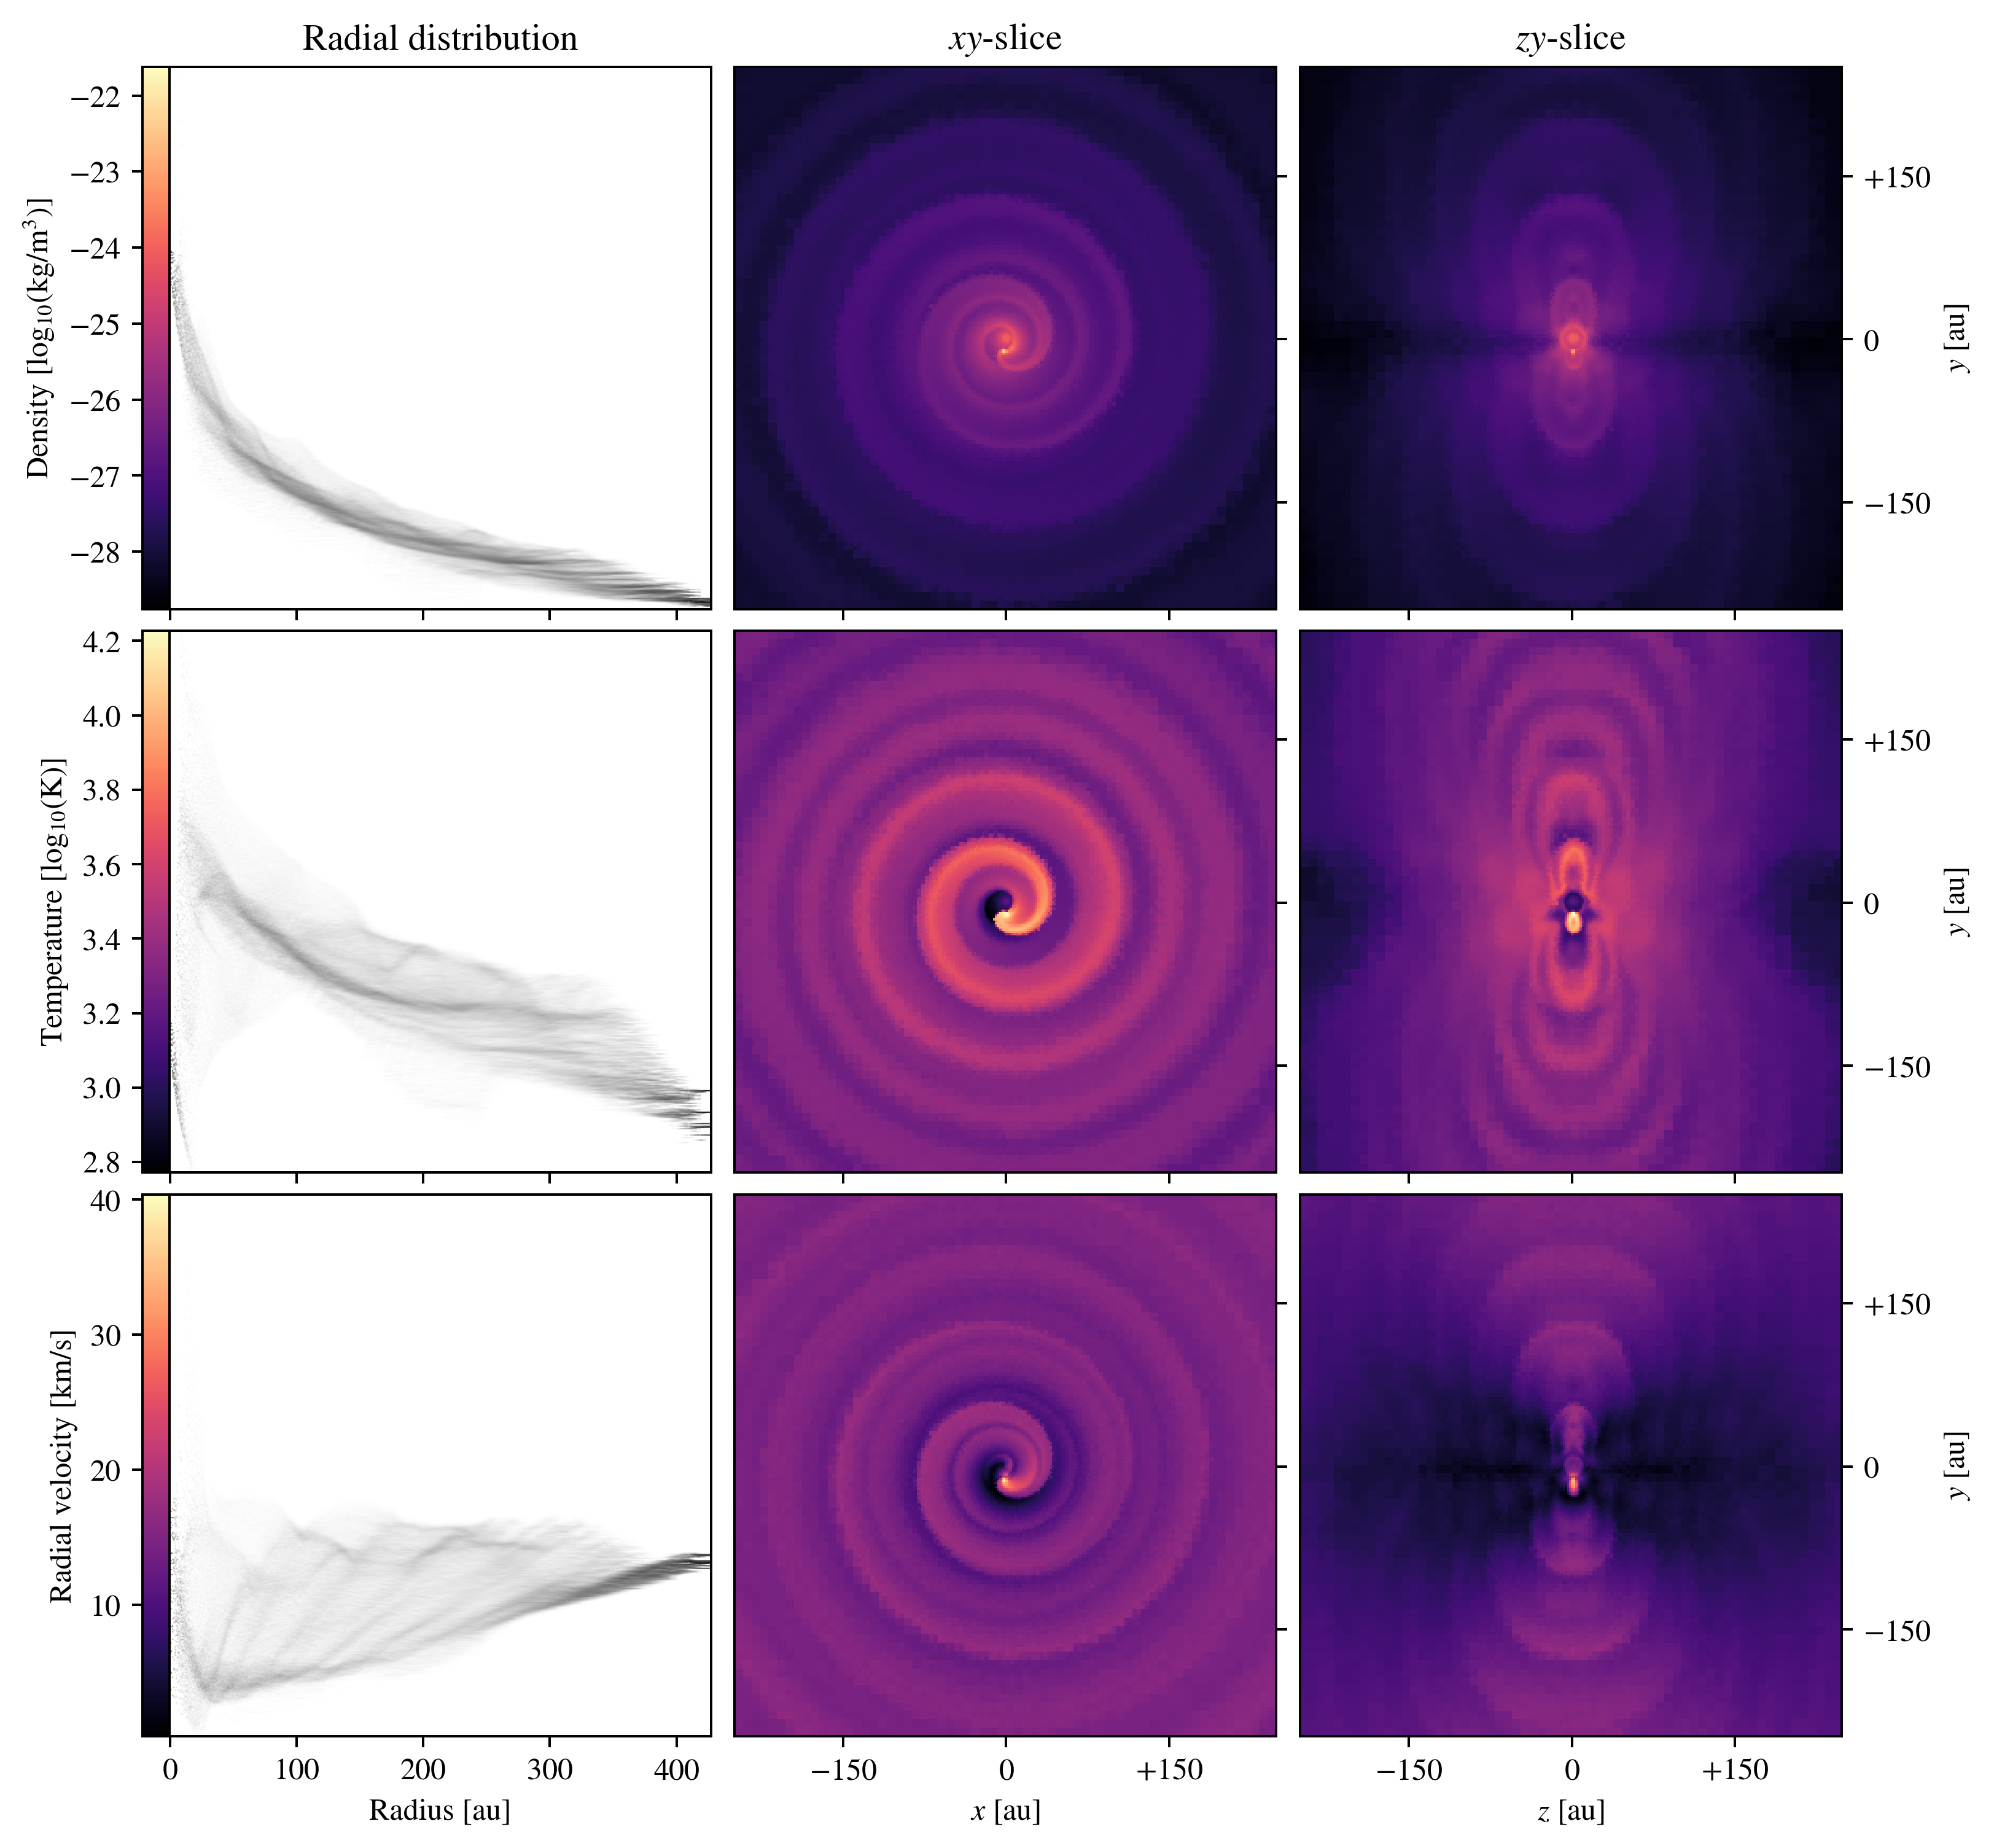

In [10]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

cmap = 'magma' #cubehelix'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(rho_dat)
data_min = data.min()
data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))[0]
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[0,1].imshow(data[:,  :,128].T, vmin=data_min, vmax=data_max, cmap=cmap)
pp = axs[0,2].imshow(data[128, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([51, 128, 205], [])
axs[0,1].set_yticks([51, 128, 205], [])
axs[0,2].set_xticks([51, 128, 205], [])
axs[0,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='Density [log$_{10}$(kg/m$^{3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_dat)
data_min = data.min()
data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))[0]
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[1,1].imshow(data[:,  :,128].T, vmin=data_min, vmax=data_max, cmap=cmap)
pp = axs[1,2].imshow(data[128, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([51, 128, 205], [])
axs[1,1].set_yticks([51, 128, 205], [])
axs[1,2].set_xticks([51, 128, 205], [])
axs[1,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()


data = v_r / 1.0e+3
data_min = data.min()
data_max = data.max()

num = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))[0]
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
pp = axs[2,1].imshow(data[:,  :,128].T, vmin=data_min, vmax=data_max, cmap=cmap)
pp = axs[2,2].imshow(data[128, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap)
# axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
axs[2,1].set_yticks([51, 128, 205], [])
axs[2,2].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
axs[2,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig('phantom_model.png', dpi=360, bbox_inches='tight')

In [8]:
nCO_dat.shape

(256, 256, 256)

In [8]:
num = np.histogram2d(rs.ravel(), data.ravel(), bins=(400,300))

In [9]:
np.sqrt(2) * 200

282.842712474619

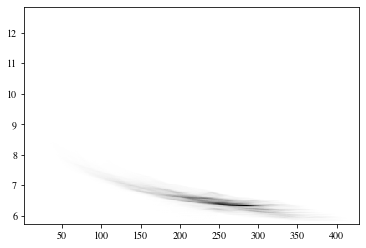

In [10]:
data = np.log10(nCO_dat)




plt.hist2d(rs.ravel(), data.ravel(), bins=(400,300), cmap='Greys')
plt.show()

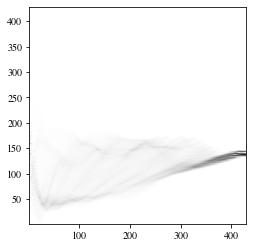

In [11]:
plt.imshow(np.flip(np.log(num[0].T/num[0].sum(axis=1)+1.0e-1), axis=0), cmap='Greys', extent=(num[1][0], num[1][-1], num[2][0], num[1][-1]))
# plt.imshow(np.flip((num.T+1.0e-2), axis=0), cmap='Greys')

In [12]:
coords = model_test.get_coords(origin='centre')

In [13]:
coords.shape

(3, 256, 256, 256)

In [14]:
print(coords[0].min(), coords[0].max())

-37189911189353.07 37189911189353.07


In [15]:
print(coords[1].min(), coords[1].max())

-37162633924652.88 37162633924652.88


In [16]:
print(coords[2].min(), coords[2].max())

-36662498732177.9 36662498732177.9


In [17]:
(37162633924652.88 * units.m).to(units.au)

<Quantity 248.41686416 AU>

In [18]:
248 * np.sqrt(3)

429.54860027708156

In [19]:
248 / 2

124.0

In [20]:
128 / 248 * 150

77.41935483870968

In [21]:
128 - 77

51

In [22]:
128 + 77

205

# CO
---

In [12]:
32 / 248 * 150

19.35483870967742

In [13]:
32-19

13

In [14]:
32+19

51

In [15]:
from pomme.model import TensorModel, SphericallySymmetric

In [16]:
model = TensorModel.load('models/model_3D_CO_all.h5')

In [17]:
from run_CO import analytic_velo, analytic_T

rs_mini = model.get_radius(origin='centre')
rs_mini /= (1.0 * units.au).si.value
r_in    = rs_mini.min()

/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


In [18]:
velo = analytic_velo(
    r     = torch.from_numpy(rs_mini),
    r_in  = r_in,
    v_in  = torch.exp(model['log_v_in']),
    v_inf = torch.exp(model['log_v_inf']),
    beta  =           model['beta']
)

temp = analytic_T(
    r       = torch.from_numpy(rs_mini),
    r_in    = r_in,
    T_in    = torch.exp(model['log_T_in']),
    epsilon = torch.exp(model['log_epsilon'])
)

In [19]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  beta                       Free          False    +2.518e+00     +2.518e+00     +2.518e+00
  log_CO                     Free          True     +1.112e+01     +1.485e+01     +2.680e+01
  log_T_in                   Free          False    +8.130e+00     +8.130e+00     +8.130e+00
  log_epsilon                Free          False    -3.191e+00     -3.191e+00     -3.191e+00
  log_v_in                   Free          False    +3.372e+00     +3.372e+00     +3.372e+00
  log_v_inf                  Fixed         False    +9.473e+00     +9.473e+00     +9.473e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


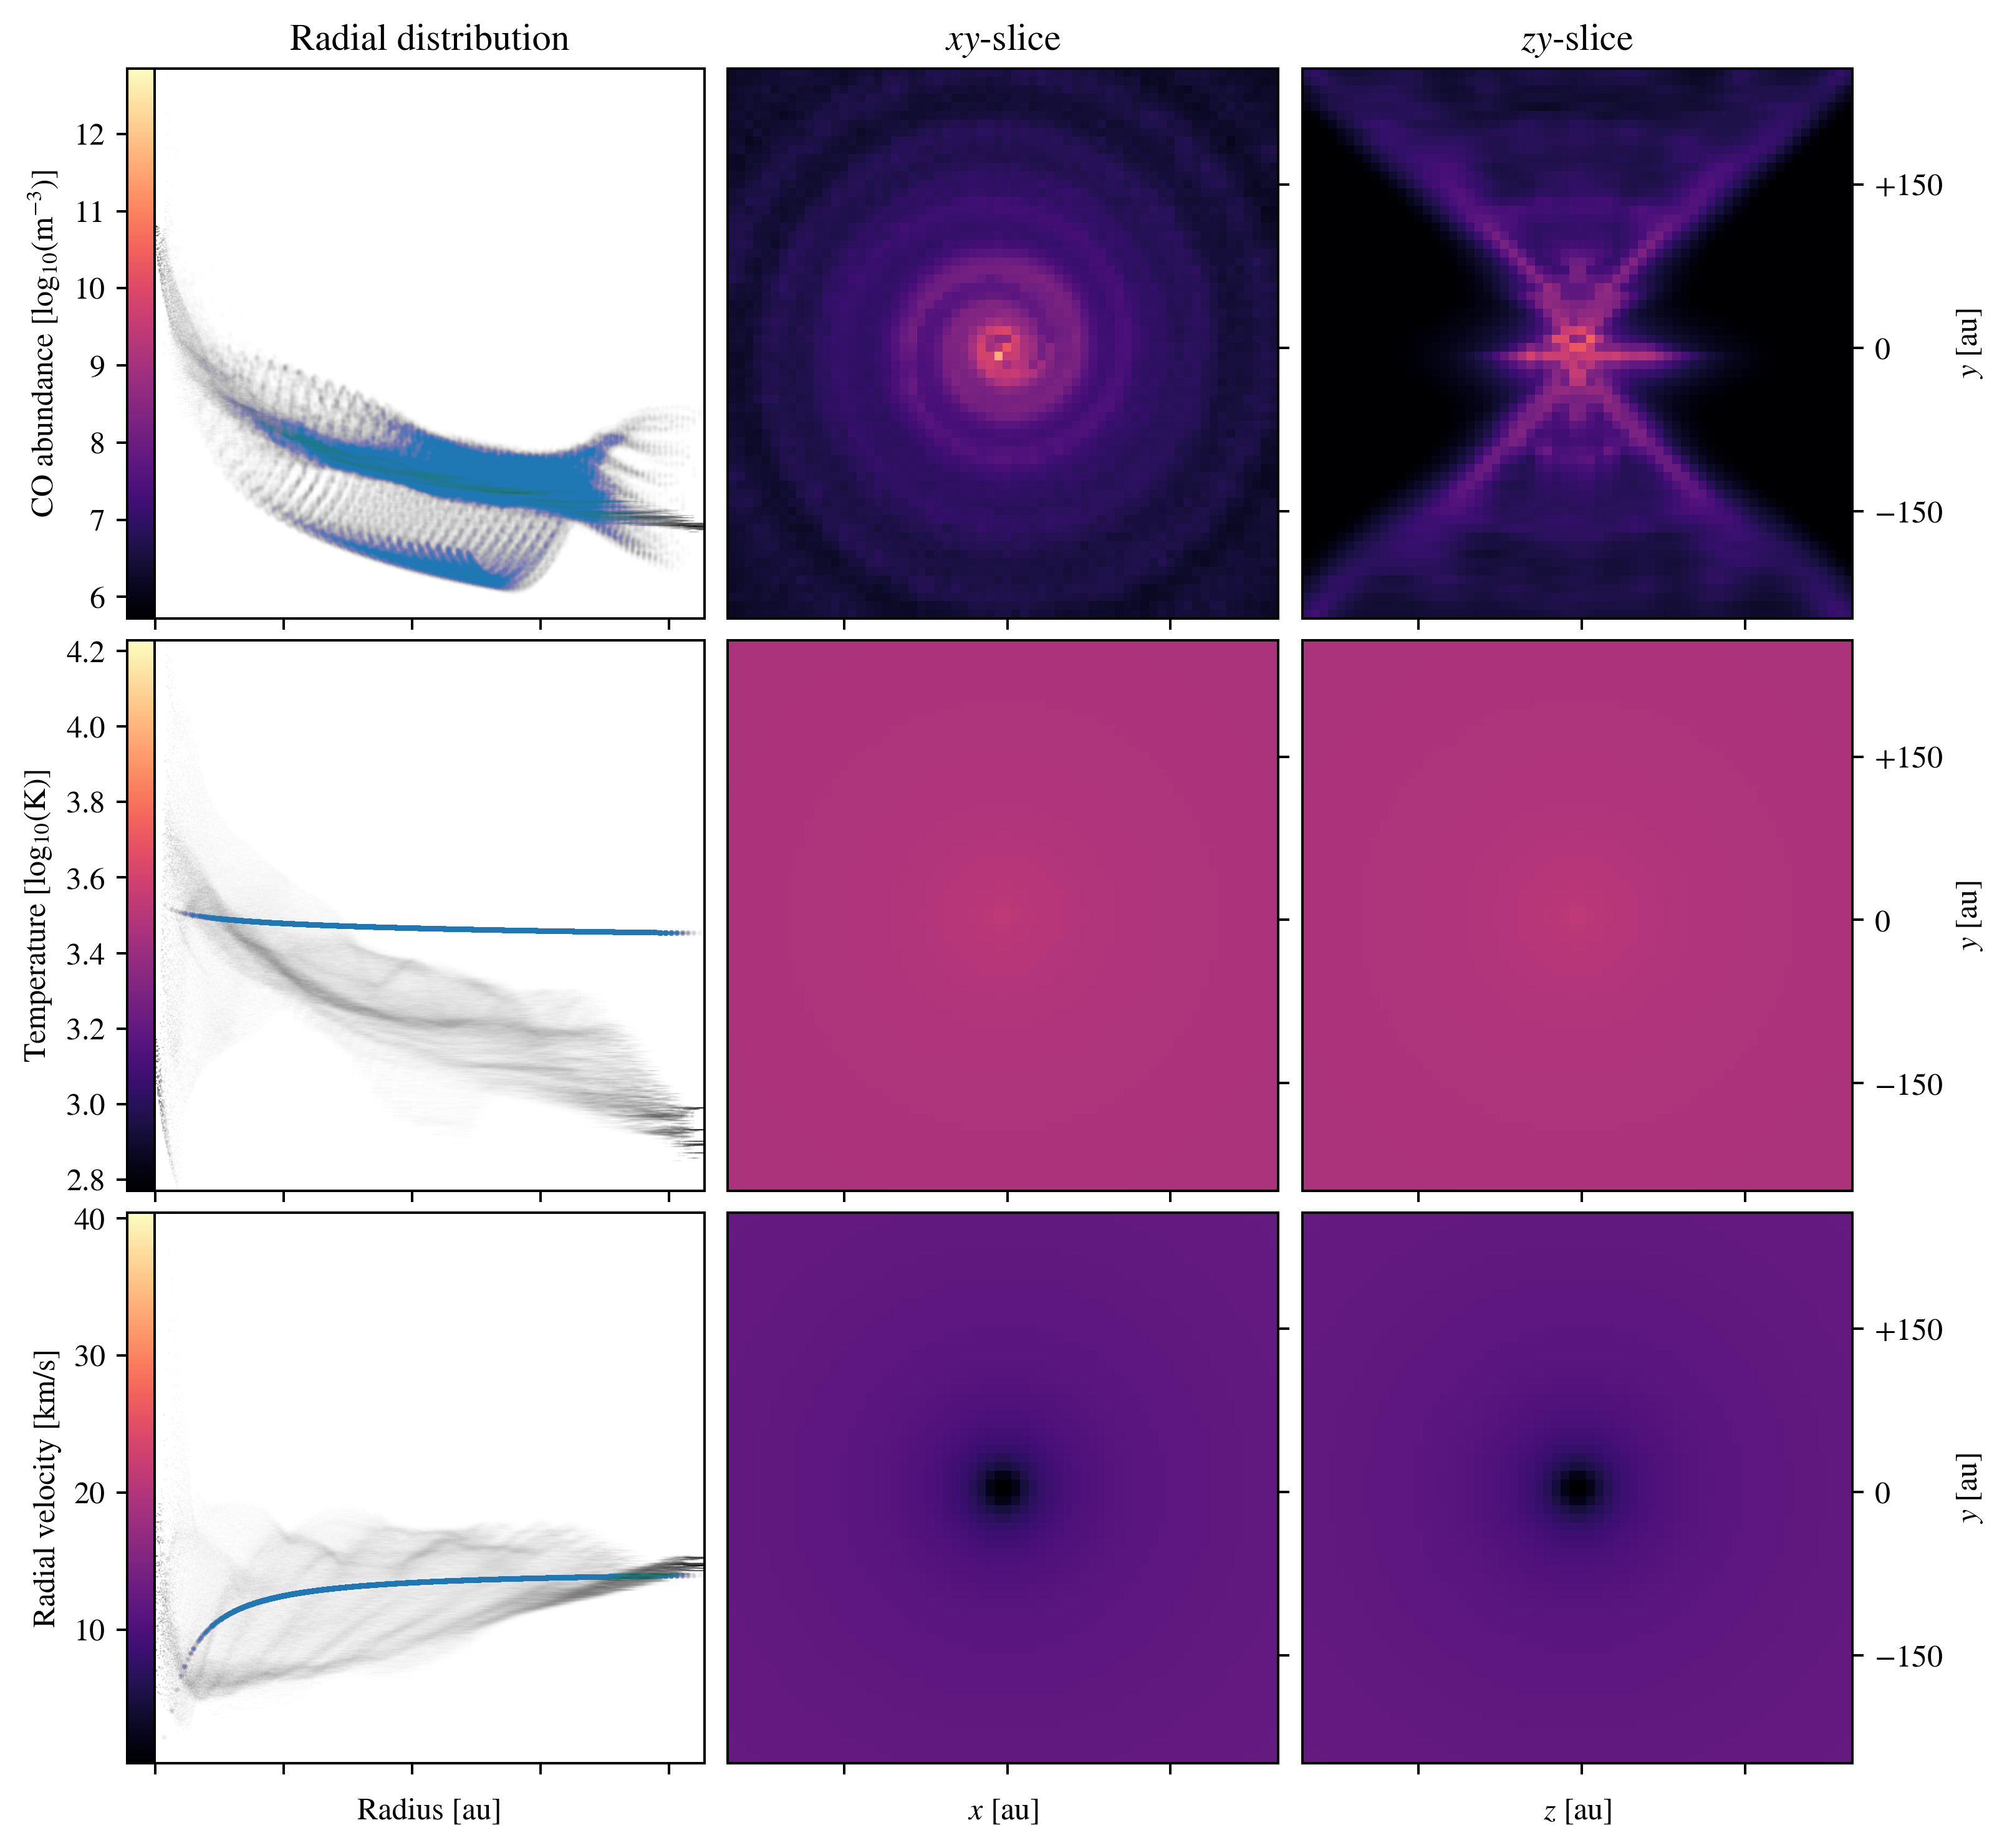

In [20]:
fig, axs = plt.subplots(3,3, dpi=360, figsize=(10.4,10), gridspec_kw={'width_ratios':[1.15,1,1], 'wspace':0.0, 'hspace':0.04})

im150  = 13
centre = 32
ip150  = 51

cmap = 'magma' #cubehelix'
cmap2 = 'magma'
alpha = 0.03

axs[0,0].set_title("Radial distribution")
axs[0,1].set_title("$xy$-slice")
axs[0,2].set_title("$zy$-slice")

data = np.log10(nCO_dat)
data_min = data.min()
data_max = data.max()

data2 = (model['log_CO']/np.log(10.0)).data.numpy()
data2_min = data2.min()
data2_max = data2.max()

# num = np.histogram2d(rs_mini.ravel(), data.ravel(), bins=(428,428))[0]
num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[0,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[0,0].scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys), s=1, c='tab:blue', alpha=0.005)
pp = axs[0,1].imshow(data2[:,  :,centre].T, vmin=data_min, vmax=data_max, cmap=cmap2)
pp = axs[0,2].imshow(data2[centre, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap2)
axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])
axs[0,1].set_xticks([im150, centre, ip150], [])
axs[0,1].set_yticks([im150, centre, ip150], [])
axs[0,2].set_xticks([im150, centre, ip150], [])
axs[0,2].set_yticks([im150, centre, ip150], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[0,0], location='left', pad=0, label='CO abundance [log$_{10}$(m$^{-3})$]')
axs[0,1].yaxis.tick_right()
axs[0,2].yaxis.tick_right()
# axs[0,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')

data = np.log10(tmp_dat)
data_min = data.min()
data_max = data.max()

data2 = (torch.log(temp)/np.log(10.0)).data.numpy()
data2_min = data2.min()
data2_max = data2.max()

# num = np.histogram2d(rs_mini.ravel(), data.ravel(), bins=(428,428))[0]
num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[1,0].scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys), s=1, c='tab:blue', alpha=0.005)
pp = axs[1,1].imshow(data2[:,  :,centre].T, vmin=data_min, vmax=data_max, cmap=cmap2)
pp = axs[1,2].imshow(data2[centre, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap2)
axs[1,0].set_xticklabels([])
axs[1,0].set_yticklabels([])
axs[1,1].set_xticks([im150, centre, ip150], [])
axs[1,1].set_yticks([im150, centre, ip150], [])
axs[1,2].set_xticks([im150, centre, ip150], [])
axs[1,2].set_yticks([im150, centre, ip150], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
axs[1,1].yaxis.tick_right()
axs[1,2].yaxis.tick_right()
# axs[1,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')

# data = np.log10(tmp_dat)
# data_min = data.min()
# data_max = data.max()

# data = np.log10(tmp_dat)
# data_min = data.min()
# data_max = data.max()

# num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
# axs[1,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
# axs[1,0].scatter(rs_mini.ravel(), len(ys)-(torch.log10(temp).data.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys), s=1, c='tab:blue', alpha=0.005)
# pp = axs[1,1].imshow(data[:,  :,128].T, vmin=data_min, vmax=data_max, cmap=cmap)
# pp = axs[1,2].imshow(data[128, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap)
# axs[1,0].set_xticklabels([])
# axs[1,0].set_yticklabels([])
# axs[1,1].set_xticks([51, 128, 205], [])
# axs[1,1].set_yticks([51, 128, 205], [])
# axs[1,2].set_xticks([51, 128, 205], [])
# axs[1,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
# fig.colorbar(pp, ax=axs[1,0], location='left', pad=0, label='Temperature [log$_{10}$(K)]')
# axs[1,1].yaxis.tick_right()
# axs[1,2].yaxis.tick_right()

data = v_r / 1.0e+3
data_min = data.min()
data_max = data.max()

data2 = (velo / 1.0e+3).data.numpy()
data2_min = data2.min()
data2_max = data2.max()

# num = np.histogram2d(rs_mini.ravel(), data.ravel(), bins=(428,428))[0]
num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
axs[2,0].scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys), s=1, c='tab:blue', alpha=0.005)
pp = axs[2,1].imshow(data2[:,  :,centre].T, vmin=data_min, vmax=data_max, cmap=cmap2)
pp = axs[2,2].imshow(data2[centre, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap2)
axs[2,0].set_xticklabels([])
axs[2,0].set_yticklabels([])
axs[2,1].set_xticks([im150, centre, ip150], [])
axs[2,1].set_yticks([im150, centre, ip150], [])
axs[2,2].set_xticks([im150, centre, ip150], [])
axs[2,2].set_yticks([im150, centre, ip150], ['$+150$', '$0$', '$-150$'])
fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
axs[2,1].yaxis.tick_right()
axs[2,2].yaxis.tick_right()
# axs[1,0].set_aspect(abs(np.diff(axs[0,0].get_xlim())[0] / np.diff(axs[0,0].get_ylim())[0]))
axs[2,0].set_aspect('equal')
axs[2,1].set_aspect('equal')

# data = v_r / 1.0e+3
# data_min = data.min()
# data_max = data.max()

# num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
# axs[2,0].imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
# axs[2,0].scatter(rs_mini.ravel(), len(ys)-(velo.data.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys)/1.0e+3, s=1, c='tab:blue', alpha=0.005)
# pp = axs[2,1].imshow(data[:,  :,128].T, vmin=data_min, vmax=data_max, cmap=cmap)
# pp = axs[2,2].imshow(data[128, :, :]  , vmin=data_min, vmax=data_max, cmap=cmap)
# # axs[2,0].set_xticklabels([])
# axs[2,0].set_yticklabels([])
# axs[2,1].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
# axs[2,1].set_yticks([51, 128, 205], [])
# axs[2,2].set_xticks([51, 128, 205], ['$-150$', '$0$', '$+150$'])
# axs[2,2].set_yticks([51, 128, 205], ['$+150$', '$0$', '$-150$'])
# fig.colorbar(pp, ax=axs[2,0], location='left', pad=0, label='Radial velocity [km/s]')
# axs[2,1].yaxis.tick_right()
# axs[2,2].yaxis.tick_right()

axs[0,0].set_aspect(1 / axs[0,0].get_data_ratio())
axs[1,0].set_aspect(1 / axs[1,0].get_data_ratio())
axs[2,0].set_aspect(1 / axs[2,0].get_data_ratio())


axs[2,0].set_xlabel('Radius [au]')
axs[2,1].set_xlabel('$x$ [au]')
axs[2,2].set_xlabel('$z$ [au]')
axs[0,2].set_ylabel('$y$ [au]')
axs[1,2].set_ylabel('$y$ [au]')
axs[2,2].set_ylabel('$y$ [au]')

axs[0,2].yaxis.set_label_position('right')
axs[1,2].yaxis.set_label_position('right')
axs[2,2].yaxis.set_label_position('right')

plt.savefig('phantom_model_CO_all.png', dpi=360, bbox_inches='tight')

In [49]:
num.max()

3159.0

In [42]:
temp.min()

tensor(2629.6272, dtype=torch.float64, grad_fn=<MinBackward1>)

In [43]:
temp.max()

tensor(3847.3589, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [191]:
r = model.get_radius(origin='centre')

In [31]:
temp.min()

tensor(23661.7750, dtype=torch.float64, grad_fn=<MinBackward1>)

In [109]:
data = np.log10(torch.exp(model['log_CO']).data.numpy())
data_min = data.min()
data_max = data.max()

In [110]:
data2.max()

11.999999999999998

In [200]:
model['log_CO'].max()

tensor(82250.6421, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [47]:
velo.data.ravel().max()

tensor(633.2850, dtype=torch.float64)

In [48]:
velo.data.ravel().min()

tensor(0.1998, dtype=torch.float64)

In [56]:
num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))

In [32]:
np.exp(-5)

0.006737946999085467

10.622001931198579

In [61]:
d = velo.data.ravel()/1.0e+3

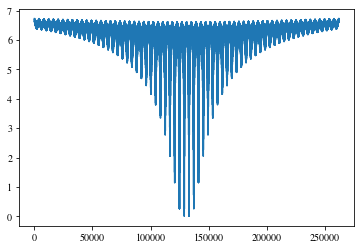

In [62]:
plt.plot(d * (len(ys)/ys[-1]) )

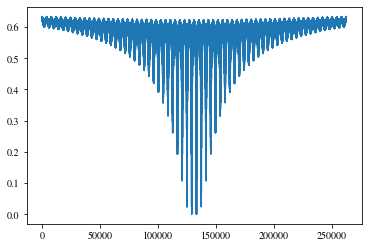

In [65]:
plt.plot(d)

In [67]:
torch.exp(model['log_v_inf'])

tensor(681.3723, dtype=torch.float64, grad_fn=<ExpBackward0>)

In [68]:
model['log_v_inf']

tensor(6.5241, dtype=torch.float64, requires_grad=True)

In [44]:
torch.exp(model['log_T_in'])

tensor(5000.0000, dtype=torch.float64, grad_fn=<ExpBackward0>)

In [46]:
model['log_T_in']/np.log(10)

tensor(3.6990, dtype=torch.float64, grad_fn=<DivBackward0>)

In [70]:
np.exp(9.388)

11944.18705383265

In [33]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  beta                       Free          False    +4.156e+00     +4.156e+00     +4.156e+00
  log_CO                     Free          True     +1.706e+01     +1.738e+01     +2.765e+01
  log_T_in                   Free          False    +1.011e+01     +1.011e+01     +1.011e+01
  log_epsilon                Free          False    -4.587e+00     -4.587e+00     -4.587e+00
  log_v_in                   Free          False    +1.463e+00     +1.463e+00     +1.463e+00
  log_v_inf                  Fixed         False    +9.510e+00     +9.510e+00     +9.510e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [7.46717267e+13 7.46169581e+13 7.36127621e+13]
shape: (64, 64, 64)


In [105]:
np.exp(-1.247)

0.28736560181259563

In [34]:
np.exp(10)

22026.465794806718

In [57]:
data = np.log10(nCO_dat)
data_min = data.min()
data_max = data.max()

data2 = (model['log_CO']/np.log(10.0)).data.numpy()

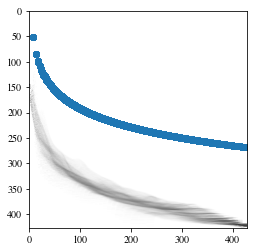

In [78]:
num, xs, ys = np.histogram2d(rs.ravel(), data.ravel(), bins=(428,428))
plt.imshow(np.flip(np.log(num.T/num.sum(axis=1)+1.0e-2), axis=0), cmap='Greys')
# plt.scatter(rs_mini.ravel(), data2.ravel()*(len(ys)), s=1, c='tab:blue', alpha=0.1)

plt.scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys))

In [61]:
len(ys)

429

In [64]:
data2.min()

8.401318901092836

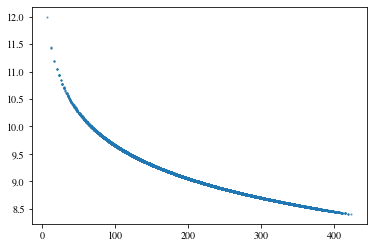

In [68]:
plt.scatter(rs_mini.ravel(), data2.ravel(), s=1, c='tab:blue', alpha=0.1)

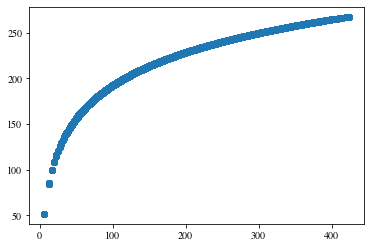

In [77]:
plt.scatter(rs_mini.ravel(), len(ys)-(data2.ravel()-ys[0])/(ys[-1]-ys[0])*len(ys))